In [42]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import neighbors
from sklearn.cluster import KMeans
from pycaret.clustering import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA,TruncatedSVD
import sklearn_recommender as skr

In [43]:
data = pd.read_csv('data/people_chennai.csv')

In [44]:
data.columns

Index(['Employee ID', 'Name', 'Gender', 'Role', 'Grade', 'Hire Date',
       'Home Office', 'Current Working Office', 'Staffing Office',
       'Total Years of EXP', 'TW Years of EXP', 'Skills'],
      dtype='object')

In [45]:
data.Role.describe()

count           308
unique           27
top       Developer
freq            171
Name: Role, dtype: object

In [46]:
data.Grade.describe()

count                   308
unique                   10
top       Senior Consultant
freq                    117
Name: Grade, dtype: object

In [47]:
data.Gender.describe()

count     308
unique      3
top       Man
freq      199
Name: Gender, dtype: object

In [48]:
data.Skills

0      [Expert]: Tamil;\n[Experienced]: Docker,Go CD,...
1      [Experienced]: English,Hindi;\n[Moderate]: C++...
2      [Expert]: Presenting,Teaching,English,Tamil;\n...
3                                                    NaN
4      [Expert]: Defect management,Manual/Exploratory...
                             ...                        
303                                                  NaN
304    [Experienced]: React,React Native,Redux ,Respo...
305    [Expert]: Tamil;\n[Experienced]: CSS,Feedback ...
306    [Experienced]: Defect management,Manual/Explor...
307                                                  NaN
Name: Skills, Length: 308, dtype: object

In [49]:
data.Skills.apply(lambda x:str(x).replace("[Expert]: ","").replace(";\n",",").replace("[Experienced]: ",""))

0      Tamil,Docker,Go CD,Golang,Java,Javascript,Node...
1      English,Hindi,[Moderate]: C++,HTML,Manual/Expl...
2      Presenting,Teaching,English,Tamil,ElasticSearc...
3                                                    nan
4      Defect management,Manual/Exploratory Testing,J...
                             ...                        
303                                                  nan
304    React,React Native,Redux ,Responsive Web Desig...
305    Tamil,CSS,Feedback & Coaching,English,[Moderat...
306    Defect management,Manual/Exploratory Testing,R...
307                                                  nan
Name: Skills, Length: 308, dtype: object

In [50]:
def return_column(skills_input,level):
    skill = list()
    skills = skills_input.replace(";\n","#$")
    if f"[{level}]: " in skills:
        replace_str = f"[{level}]: "
        curr_str_index = skills.find(replace_str)
        curr_end_index = skills.find("#$",curr_str_index)
        if curr_end_index == -1:
            skill.extend(skills[curr_str_index].replace(replace_str,"").split(","))
        else:
            skill.extend(skills[curr_str_index:curr_end_index].replace(replace_str,"").split(","))
    return skill

In [51]:
all_skills = []
for index, row in data.iterrows():
    skill_row = str(row['Skills'])
    all_skills.extend(return_column(skill_row,'Expert'))
    all_skills.extend(return_column(skill_row,'Moderate'))        
    all_skills.extend(return_column(skill_row,'Beginner'))        
    all_skills.extend(return_column(skill_row,'Experienced'))        
    all_skills.extend(return_column(skill_row,'Want to learn'))        

In [52]:
all_skills = list(set(all_skills))
all_skills.remove('[')

In [53]:
len(all_skills)

259

In [54]:
all_skills

['Tamil',
 'Bootstrap ',
 'Jade',
 'PowerShell ',
 'AngularJS ',
 'Portuguese',
 'ActiveMQ',
 'Content Strategy',
 'Pig',
 'Open Stack',
 'Manufacturing',
 'Groovy',
 'Hive',
 'Java',
 'Gulp',
 'SOAP',
 'Spanish',
 'Consul / ZooKeeper / Service Discovery',
 'Cassandra',
 'Oracle',
 'CircleCI ',
 'Synthesis',
 'Arduino',
 'Google Compute Engine/Cloud',
 'Communication',
 'Objective C',
 'Dynatrace',
 'Planning',
 'Security testing',
 'System thinking',
 'Mobile test automation - iOS',
 'Istio',
 'Data Center applications',
 'Java test automation',
 'Couchbase',
 'Jenkins',
 'Business Vision & Context Analysis ',
 'Capybara',
 'Chaos Testing ',
 'CloudFormation',
 'Responsive Web Design',
 'Haskell',
 'Mobile Web',
 'SASS/SCSS',
 'Visual Design',
 'Golang',
 'HTML',
 'Prometheus',
 'Gherkin ',
 'Angular (version 2+) ',
 'TypeScript',
 'Questioning',
 'Microsoft SQL ',
 'Interaction Design',
 'Node JS',
 'UI Development',
 'Javascript',
 'Javascript visualization libraries (D3.js)',
 'Non

In [55]:
len(all_skills)

259

In [56]:
skills_df = pd.DataFrame(np.zeros((data.shape[0],len(all_skills))),columns=all_skills)

In [57]:
people_skills = pd.concat([data,skills_df],axis=1)

In [58]:
def add_skill(row,skill_name,skill_level,skill_cols):
    skill_row = str(row['Skills'])
    skill_person = return_column(skill_row,skill_name)
    for skill in skill_person:
        if skill in skill_cols:
            row[skill] = skill_level
    return row

In [59]:
people_skills_map = people_skills.apply(lambda x: add_skill(x,'Expert',4,people_skills.columns),axis=1).apply(lambda x: add_skill(x,'Experienced',3,people_skills.columns),axis=1).apply(lambda x: add_skill(x,'Moderate',2,people_skills.columns),axis=1).apply(lambda x: add_skill(x,'Beginner',1,people_skills.columns),axis=1)

In [60]:
people_data = people_skills_map.drop(columns=['Home Office','Current Working Office','Staffing Office','Skills','Name','Hire Date'])

In [61]:
people_data.columns

Index(['Employee ID', 'Gender', 'Role', 'Grade', 'Total Years of EXP',
       'TW Years of EXP', 'Tamil', 'Bootstrap ', 'Jade', 'PowerShell ',
       ...
       'Microservices', 'Java application development', 'Feedback & Coaching',
       'F#', 'Puppet ', 'Twist', 'JMS - Java Message Service', 'Vertica',
       'Inception', 'PHP'],
      dtype='object', length=265)

In [62]:
setup(people_data,normalize=True, normalize_method='minmax',pca=True,pca_components=0.7)

Setup Succesfully Completed!


,Description,Value
0,session_id,2877
1,Original Data,"(308, 265)"
2,Missing Values,False
3,Numeric Features,244
4,Categorical Features,21
5,Ordinal Features,False
6,High Cardinality Features,False
7,Transformed Data,"(308, 31)"
8,Numeric Imputer,mean
9,Categorical Imputer,constant


(     Component_1  Component_2  Component_3  Component_4  Component_5  \
 0       0.017874    -0.499913     0.123025     0.998282    -0.431020   
 1      -0.037549     1.459047     0.574254     0.770839     0.426928   
 2       0.918760    -0.042799    -1.334854     1.206642     0.311673   
 3      -1.500802     0.058704     0.160101    -0.720927    -0.055236   
 4       0.143833     1.264119     2.107825     1.074510     0.593716   
 ..           ...          ...          ...          ...          ...   
 303    -1.509756    -0.067859    -0.026176    -0.503800     0.581128   
 304     1.402227    -0.347906    -1.210256     1.153735    -0.024850   
 305     0.384642    -0.019196    -0.712961     1.258683     0.269248   
 306     0.125852     1.670500    -0.150047    -0.581553     0.689541   
 307    -1.604600     0.007445     0.092072    -0.740134     0.036798   
 
      Component_6  Component_7  Component_8  Component_9  Component_10  ...  \
 0      -0.905779    -0.417854    -0.274192

In [63]:
model = create_model('kmeans',num_clusters=5)

,Metric
Silhouette,0.1464
Calinski-Harabasz,36.9121
Davies-Bouldin,2.1122


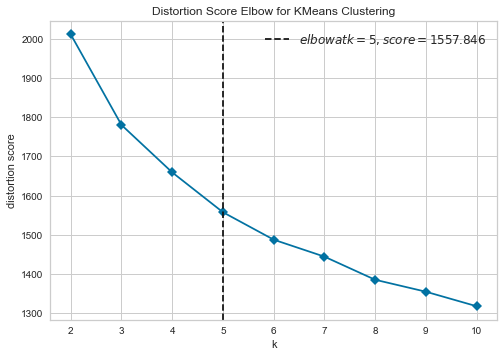

In [64]:
plot_model(model,plot='elbow') 

In [65]:
plot_model(model,plot='distribution') 

In [66]:
plot_model(model,plot='tsne') 

In [67]:
predictions = predict_model(model, data = people_data)

In [68]:
def get_match(emp_id):
    joined = pd.merge(data, predictions)
    cluster = joined[joined['Employee ID'] == emp_id]['Cluster'].values[0]
    return joined[joined['Cluster'] == cluster]['Name']

In [69]:
get_match(21824)

6                Amit Bikram Dash
15              Aravind Kumar P L
26           Arun Sundaralingam M
28               Arunvel Sriram S
29              Arvind Thangamani
34                Balaji Arumugam
35               Balaji Sivakumar
36               Balaji Sivaraman
38           Balanagammal Murugan
40                 Bharani Chennu
41            Bharani Subramaniam
46                       Birlla P
49      Chandirasekar Thiagarajan
54                Clement Lloyd P
55             Deepak Paramasivam
59         Dharanikumar Premkumar
62                 Dinesh Kumar S
73         Ginette Thomas Vellera
74            Gobinath Thangavelu
79         Guruprasad Subramanian
90                Jagdsh LK Chand
91                   Jahan Arun J
94                    Jayakumar C
101                Jeremy Jackson
111                     Kavitha R
118      Krishnaswamy Subramanian
127         Mageswaran Muthukumar
146      Muralidharan Nandhakumar
163                      Nithya N
164           

In [70]:
people_processed = pd.get_dummies(people_data)

In [71]:
people_processed

,Employee ID,Total Years of EXP,TW Years of EXP,Tamil,Bootstrap,Jade,PowerShell,AngularJS,Portuguese,ActiveMQ,...,Grade_Associate,Grade_Consultant,Grade_Consultant - Graduate,Grade_Intern,Grade_Lead Associate,Grade_Lead Consultant,Grade_Principal Associate,Grade_Principal Consultant,Grade_Senior Associate,Grade_Senior Consultant
0,17605,5.25,5.25,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,15622,6.96,6.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,24229,3.14,1.44,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,23987,8.52,1.52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,13506,12.65,9.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,24582,3.34,1.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
304,28194,0.06,0.06,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
305,22672,2.14,2.14,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
306,26741,7.99,0.69,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [72]:
employee = people_processed[people_processed['Employee ID']==21824]
cosine =cosine_similarity(employee,people_processed)
cosine

array([[0.99999958, 0.99999951, 0.9999996 , 0.99999958, 0.99999889,
        0.99999945, 0.99999964, 0.99999951, 0.99999952, 0.99999951,
        0.99999963, 0.99999952, 0.99999956, 0.99999964, 0.99999959,
        0.99999934, 0.99999959, 0.99999934, 0.99999962, 0.99999879,
        0.99999945, 0.99999957, 0.99999963, 0.99999954, 0.99999963,
        0.99999958, 0.9999993 , 0.99999956, 0.99999958, 0.99999959,
        0.99999958, 0.99999951, 0.99999945, 0.99999952, 0.9999996 ,
        0.99999971, 0.99999949, 0.99999945, 0.99999956, 0.99999947,
        0.99999967, 0.99999865, 0.9999996 , 0.9999996 , 0.99999927,
        0.99999962, 0.99999971, 0.99999894, 0.99999945, 0.99999921,
        0.99999962, 0.99999931, 0.99999945, 0.99999866, 0.99999958,
        0.99999898, 0.99999897, 0.99999937, 0.99999945, 0.9999996 ,
        0.99999875, 0.99999952, 0.99999937, 0.99999961, 0.99999899,
        0.99999955, 0.99999949, 0.99999955, 0.99999945, 0.99999959,
        0.99999884, 0.99999951, 0.99999961, 0.99

In [73]:
tf = skr.transformer.SimilarityTransformer(cols=(1, -1), index_col='Employee ID', normalize=True)
sim_mat = tf.transform(people_processed)
def recommend(emp_id,n_records=10):
    rec = skr.recommender.SimilarityRecommender(n_records)
    rec.fit(sim_mat)
    predictions = rec.predict([emp_id])
    print(data[data['Employee ID'].isin(predictions[0])]['Name'])

In [74]:
recommend(21824,20)

47           Boojapathy Chidambaram
49        Chandirasekar Thiagarajan
55               Deepak Paramasivam
62                   Dinesh Kumar S
73           Ginette Thomas Vellera
76              Gowri Jayalakshmi R
89                  Jagan Mohan K B
91                     Jahan Arun J
94                      Jayakumar C
102                  Jeyakar J Vaiz
103     Kalaiarasi Srinivasaramanan
113                   Khaarthigha S
133                    Manikandan S
145    Mubashar Nadeem Sibgathullah
152            Nanthakumar Arumugam
154              Naveen Subramanian
165                Nithya Sivakumar
201                        Ramesh K
279         Udhayakumar Ulaganathan
287             Venkat Ramachandran
Name: Name, dtype: object


In [75]:
people_wo_id= people_processed.loc[:,people_processed.columns != 'Employee ID']
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd.fit(people_wo_id)
svd.explained_variance_ratio_.sum()

0.964452360464542